In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from xml.etree import ElementTree as ET

plt.style.use('ggplot')

%matplotlib inline

In [2]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

## Background

My wife and I have recently started to consider what life might look like after New York City. She's been here 15 years and I've been here 10 and we both agree that it's time for a change. One of the cities at the top of our list is Denver, Colorado. One of the appealing points to the city is that, unlike New York, we could afford to buy a house. This got me thinking--how can I use data science to learn more about the real estate situation in Denver? 

Fortunately for me, Denver has a great open data catalog: https://www.denvergov.org/opendata/. One of the datasets available is [Real Property Sales and Transfers](https://www.denvergov.org/opendata/dataset/city-and-county-of-denver-real-property-sales-and-transfers) which contains all records of property ownership transfers from 2008 to the present. What luck! A second dataset titled [Real Property Residential Characteristics](https://www.denvergov.org/opendata/dataset/city-and-county-of-denver-real-property-residential-characteristics) will be used to add additional information such as number of bedrooms and square footage to my analysis.

## Importing the dataset

The Real Property Sales and Transfers dataset is in relatively good shape and doesn't need too much work to clean.

In [3]:
df_sales = pd.read_csv('datasets/real_property_sales_and_transfers.csv')

C:\Program Files\Anaconda2\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
sales_dict = pd.read_excel('datasets/RealPropertyMetaData.xlsx', sheetname='Sales_Transfers', header=3, parse_cols=[1,2,3,5])
sales_dict

,Field Name,Example,Column Type,Description
0,PIN,163752899,Text,Assessor's Property Identification Number
1,SCHEDNUM,0231416005000,Text,Assessor's Schedule Number
2,RECEPTION_NUM,2011148564,Text,Clerk & Recorder's Reception Number
3,RECEPTION_DATE,20101004,Text,Clerk & Recorder's Reception Date
4,INSTRUMENT,WD,Text,Type of Instrument
5,SALE_YEAR,2010,Text,Sale Year
6,SALE_MONTHDAY,0928,Text,Sale Month/Day
7,SALE_PRICE,199677,Text,Sale Price
8,GRANTOR,"SMITH, JOHN & JANE",Text,Person(s) relinquishing ownership
9,GRANTEE,"BROWN, JAMES",Text,Person(s) recieving ownership


In [5]:
df_sales.head()

,SCHEDNUM,RECEPTION_NUM,INSTRUMENT,SALE_YEAR,SALE_MONTHDAY,RECEPTION_DATE,SALE_PRICE,GRANTOR,GRANTEE,CLASS,MKT_CLUS,D_CLASS,D_CLASS_CN,NBHD_1,NBHD_1_CN,PIN
0,3100025000,2015007009,WD,2015,120,20150121,9350000.000,PEP LENOCH DENVER V LLC &,MENIFEE MART INC,C,nan,22M,MIXED USE-HOTEL/RESD,4,GATEWAY N,163547560
1,3100028000,2014036460,WD,2014,331,20140402,7900000.000,SMITA MERCHANT INC,S&RN MANAGEMENT INC,C,nan,28T,MISC IMPS-TIE BACK,4,GATEWAY N,163556381
2,3100028000,2011125634,WD,2011,1102,20111104,5400000.000,CAMPBELL HOLDINGS,SMITA MERCHANT INC,C,nan,28T,MISC IMPS-TIE BACK,4,GATEWAY N,163556381
3,3100036000,2009028420,PS,2009,304,20090306,nan,CORPOREX HIGH POINT LLC,CORPOREX HIGH POINT LLC,A,nan,022,VCNT LAND BA-2 ZONE,4,GATEWAY N,163596315
4,3100037000,2009028420,PS,2009,304,20090306,nan,CORPOREX HIGH POINT LLC,CORPOREX HIGH POINT LLC,C,nan,223,HOTEL - RESIDENCE/SUITE,4,GATEWAY N,163596323


In [6]:
df_sales.describe()

C:\Program Files\Anaconda2\lib\site-packages\numpy\lib\function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


,SCHEDNUM,SALE_YEAR,SALE_MONTHDAY,RECEPTION_DATE,SALE_PRICE,MKT_CLUS,NBHD_1,PIN
count,234824.000,234824.000,234824.000,234824.000,165431.000,224029.000,234824.000,234824.000
mean,387336752194.890,2011.918,662.937,20120316.570,592534.596,25.768,398.547,162054260.713
std,223869952158.367,2.561,330.008,48541.241,4082154.598,17.092,235.559,1099712.526
min,3100025000.000,2008.000,101.000,130328.000,1.000,0.000,1.000,160088986.000
25%,220331003750.000,2010.000,409.000,20100325.000,nan,nan,215.000,161130939.250
50%,503409046046.000,2012.000,628.000,20120821.000,nan,nan,512.000,161810948.000
75%,527511015000.000,2014.000,923.000,20140922.000,nan,nan,588.000,163099534.250
max,915401173173.000,2016.000,1231.000,20160909.000,387500000.000,56.000,906.000,164097228.000


## Filtering the dataset to only show single family home sales

Since I'm only interested in the data about single family homes, I'll filter out everything else.

In [7]:
single_family_home = 'SINGLE FAMILY'

df_sales = df_sales[df_sales.D_CLASS_CN == single_family_home]
df_sales.shape

(139043, 16)

I'm also going to remove any records that have a sale price less than \$100,000 and more than \$600,000. Anything with a sale price less than \$50,000 indicates to me that there are some issues with the data and anything over \$600,000 is way out of my range. The next plot shows that while the number of home sales has fluctuated from year to year, the mean sale price has consistently gone up since 2009.

In [8]:
df_sales = df_sales[(df_sales.SALE_PRICE > 100000) & (df_sales.SALE_PRICE < 600000)]
df_sales.shape

(63694, 16)

That leaves me with just under 64,000 records to work with.

A quick look at the number of home sales and transfers each year shows that 2013 and 2101 were the biggest years in the dataset in terms of volume. The volume in 2015 decreased slightly. 

_Note: The dip in 2016 sales and transfers can be attributed to incomplete data since the year isn't complete._

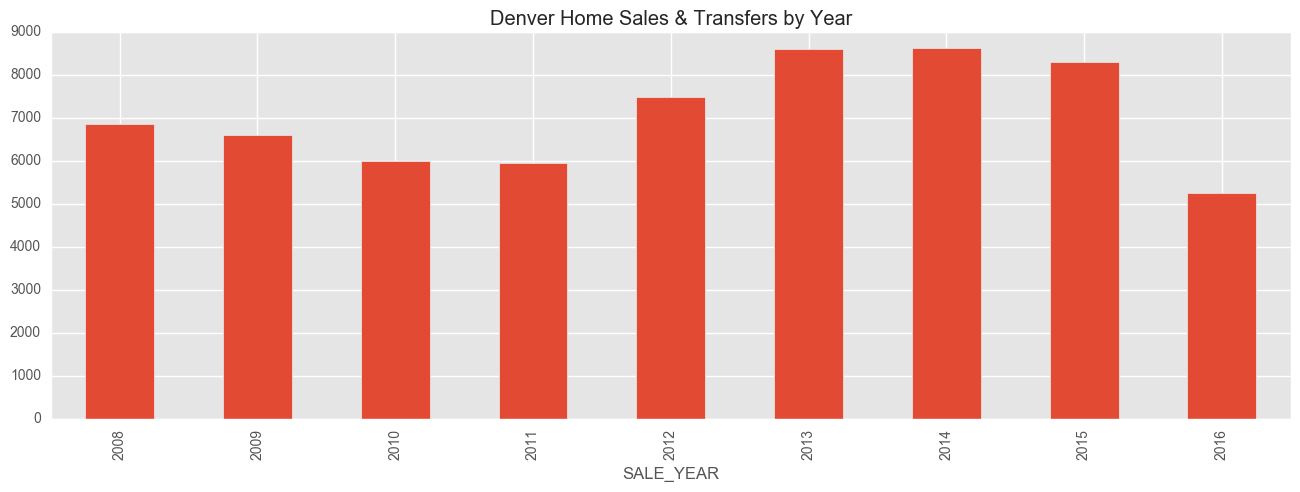

In [9]:
df_sales.groupby('SALE_YEAR').size().plot('bar', 
                                          figsize=(16, 5),
                                          title= "Denver Home Sales & Transfers by Year");

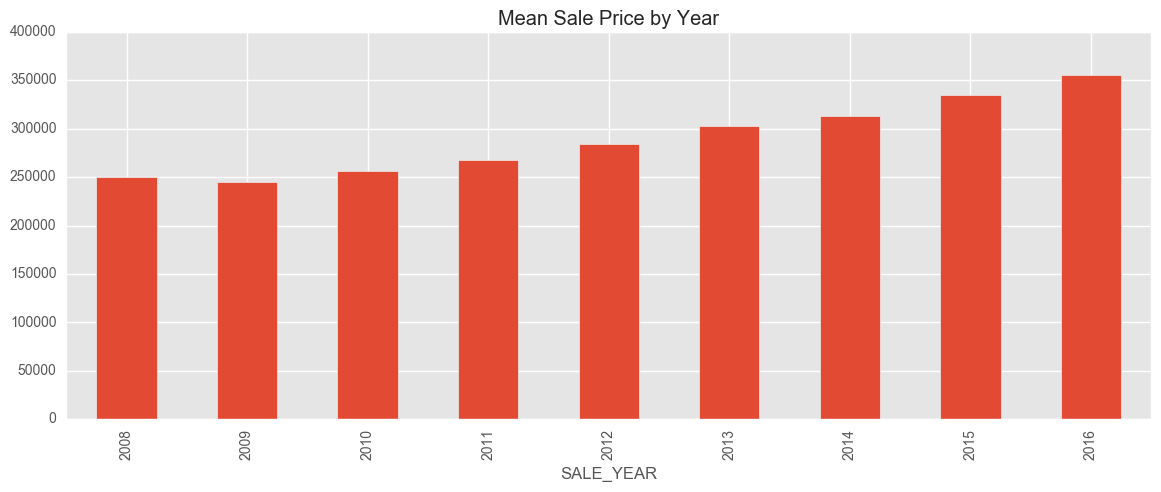

In [10]:
df_sales.groupby('SALE_YEAR')['SALE_PRICE'].mean().plot('bar', figsize=(14,5), title="Mean Sale Price by Year");

Homes seem to be getting more expensive. Not great for me.

Obviously, we want to find the right neighborhood, but we're not sure what that even means yet. As a starting point, I want to know what neighborhoods had the most sales and transfers. Plotting the neighborhoods with the highest mean sale price will tell me which neighborhoods I can't afford.

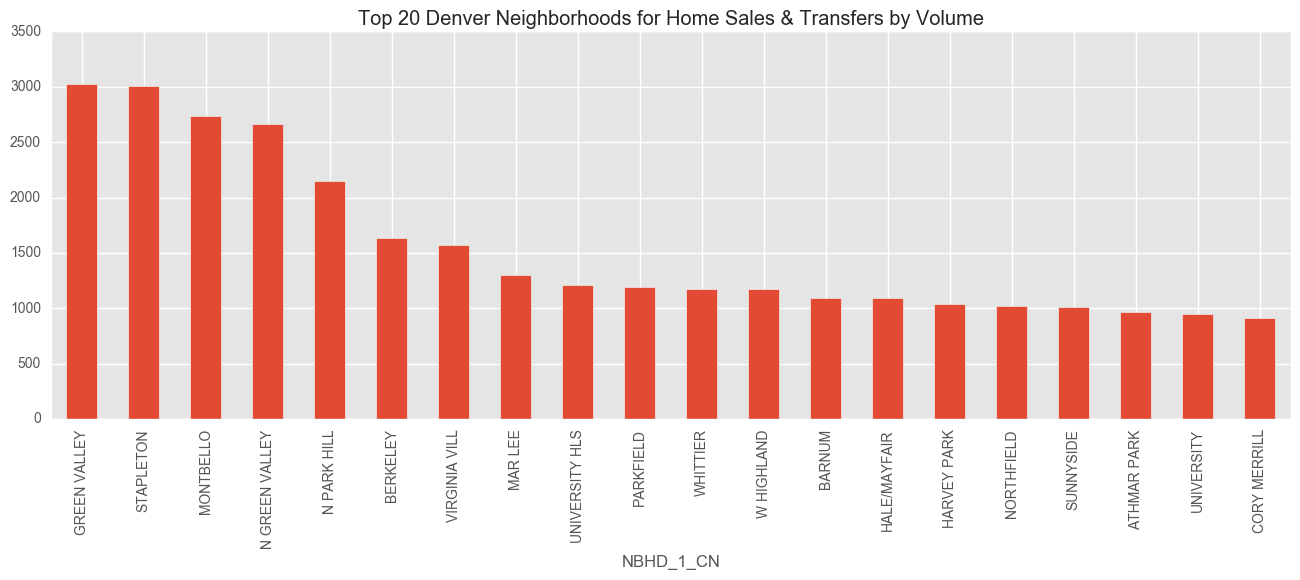

In [11]:
df_sales.groupby('NBHD_1_CN').size().sort_values(ascending=False).head(20).plot('bar', 
                                          figsize=(16, 5),
                                          title= "Top 20 Denver Neighborhoods for Home Sales & Transfers by Volume");

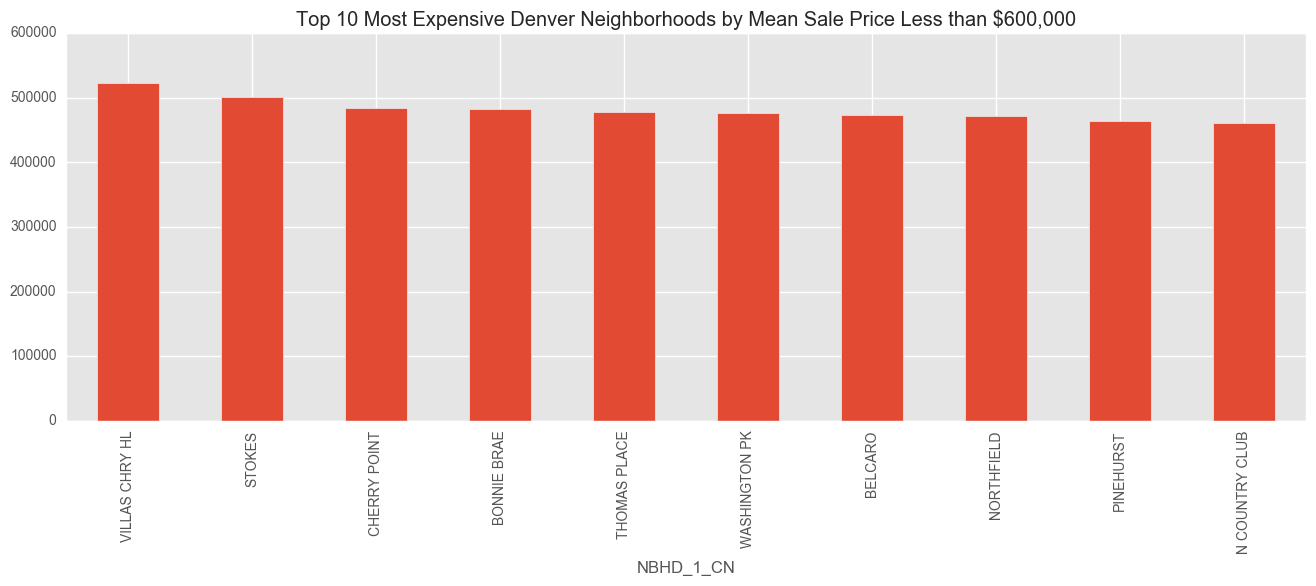

In [12]:
df_sales.groupby('NBHD_1_CN')['SALE_PRICE'].mean().sort_values(ascending=False).head(10).plot('bar', 
                                          figsize=(16, 5),
                                          title= "Top 10 Most Expensive Denver Neighborhoods by Mean Sale Price Less than $600,000");

## Adding datetime and setting it as the index

It would also be interesting to dig a little deeper into the trends that might exist in sales and transfers over time. In order to do this, I'll need to convert the SALE_YEAR and SALE_MONTHDAY columns into a new column with datetime formatting. 

In [13]:
days = []
months = []
years = df_sales.SALE_YEAR.astype(str)
datetimes = []

for row in df_sales.SALE_MONTHDAY:
    row = str(row)
    if len(row) < 4:
        row = '0' + row
    days.append(row[:-2])
    months.append(row[2:])
    
df_sales['date'] = years + '-' + months + '-' + days

df_sales['date'] = pd.to_datetime(df_sales['date'], format='%Y-%d-%m')

df_sales.index = df_sales.date

df_sales['year'] = df_sales.index.year
df_sales['month'] = df_sales.index.month
df_sales['day'] = df_sales.index.day

In [14]:
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
sales_2013 = df_sales['2013']['SALE_PRICE'].resample('M', how='count')
sales_2014 = df_sales['2014']['SALE_PRICE'].resample('M', how='count')
sales_2015 = df_sales['2015']['SALE_PRICE'].resample('M', how='count')
sales_2016 = df_sales['2016']['SALE_PRICE'].resample('M', how='count')

monthly_df = pd.DataFrame({'Month': months,
                           '2013' : sales_2013.values,
                           '2014' : sales_2014.values,
                           '2015' : sales_2015.values})

C:\Program Files\Anaconda2\lib\site-packages\ipykernel\__main__.py:2: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).count()
  from ipykernel import kernelapp as app
C:\Program Files\Anaconda2\lib\site-packages\ipykernel\__main__.py:3: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).count()
  app.launch_new_instance()
C:\Program Files\Anaconda2\lib\site-packages\ipykernel\__main__.py:4: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).count()
C:\Program Files\Anaconda2\lib\site-packages\ipykernel\__main__.py:5: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).count()


In [15]:
monthly_df.index = monthly_df.Month

### Monthly Sales Comparison

Looking at monthly sales for both 2014 and 2015 clearly shows that there are seasonal trends in home sales and transfers.

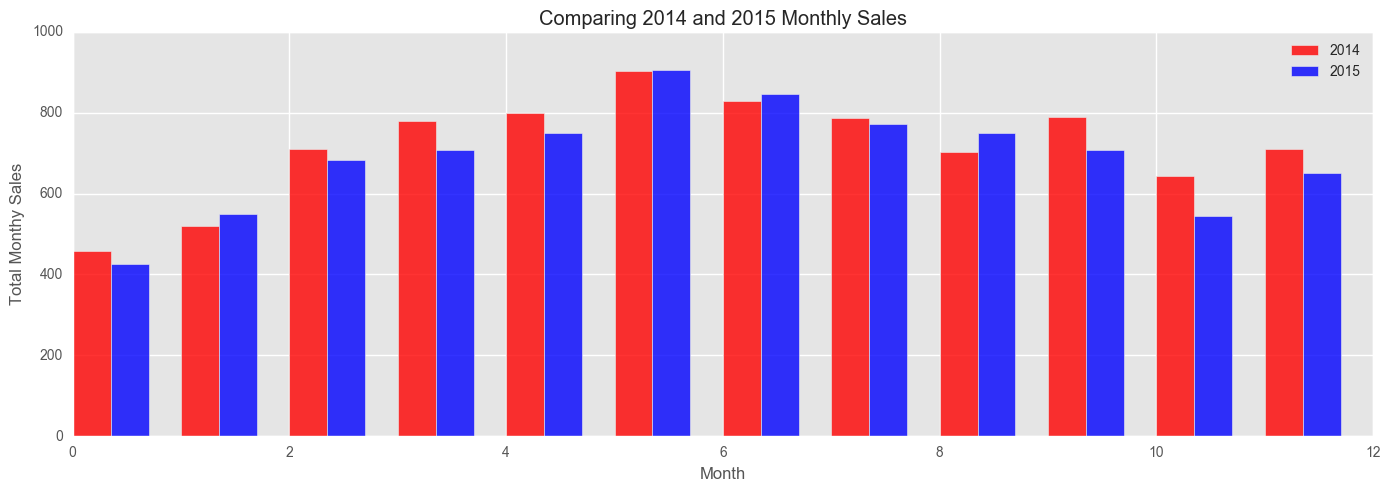

In [16]:
# data to plot
n_groups = 12

# create plot
fig, ax = plt.subplots(figsize=(14,5))
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.8
 
rects1 = plt.bar(index, monthly_df['2014'], bar_width,
                 alpha=opacity,
                 color='r',
                 label='2014')
 
rects2 = plt.bar(index + bar_width, monthly_df['2015'], bar_width,
                 alpha=opacity,
                 color='b',
                 label='2015')
 
plt.xlabel('Month')
plt.ylabel('Total Monthy Sales')
plt.title('Comparing 2014 and 2015 Monthly Sales')
plt.legend()
 
plt.tight_layout()
plt.show()

## Importing Property Characteristics dataset

Now, let's add in the Real Property Residential Characteristics dataset. It contains information about each home such as number of bedrooms and square footage. For an initial look at the data, let's see how square footage and sale price are related.

In [17]:
df_characteristics = pd.read_csv('datasets/real_property_residential_characteristics.csv', usecols=['PIN',
                                                                                          'LAND_SQFT',
                                                                                          'AREA_ABG',
                                                                                          'BSMT_AREA', 
                                                                                          'FBSMT_SQFT',
                                                                                          'GRD_AREA',
                                                                                          'BED_RMS',
                                                                                          'FULL_B',
                                                                                          'HLF_B',
                                                                                          'STYLE_CN',
                                                                                          'STORY',
                                                                                          'CCYRBLT',
                                                                                          'CCAGE_RM',
                                                                                          'ASMT_APPR_LAND',
                                                                                          'TOTAL_VALUE',
                                                                                          'ASDLAND',
                                                                                          'ASSESS_VALUE',
                                                                                          'ASMT_TAXABLE',
                                                                                          'ASMT_EXEMPT_AMT',
                                                                                          'LEGL_DESCRIPTION'], 
                                                                                          error_bad_lines=False)

In [18]:
df_full_info = df_sales.merge(df_characteristics, how='left', on='PIN')
df_full_info.dropna(inplace=True)

### df_characteristics Data Dictionary

In [19]:
characteristics_dict = pd.read_excel('datasets/RealPropertyMetaData.xlsx', 
                                     sheetname='Residential_Characteristics', 
                                     header=3, 
                                     parse_cols=[1,2,3,5],
                                     skiprows=[5,6,7,8,9,10,11,12,13,14,15,16, 17,18,19,20,21,22,23,24,25,26,27,40])
characteristics_dict

,Field Name,Example,Column Type,Description
0,PIN,161714761,Text,Assessor's Property Identification Number
1,LAND_SQFT,6241,Long Integer,Land Area
2,AREA_ABG,1411,Long Integer,Above Grade Improvement Area
3,BSMT_AREA,389,Long Integer,Basement Square Footage
4,FBSMT_SQFT,389,Long Integer,Finished Basement Area
5,GRD_AREA,0,Long Integer,Garden Level Square Footage
6,STORY,1,Float,Stories
7,STYLE_CN,TWO-STORY,Text,Architecture Style Code Definition
8,BED_RMS,3,Short Integer,Number of bedroom above grade
9,FULL_B,2,Short Integer,Total number of full baths


### Looking at Distributions of Some of the Features

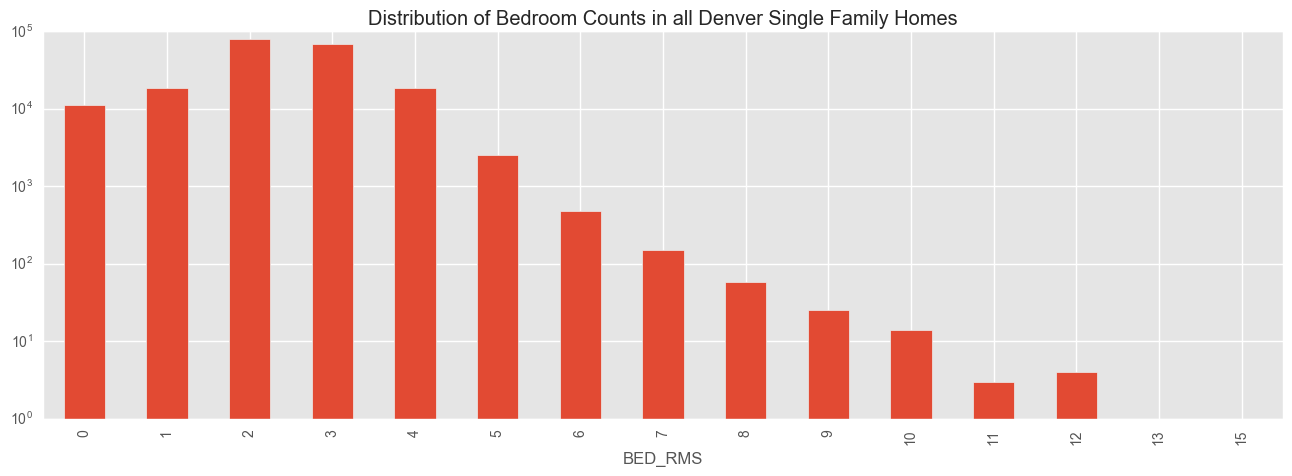

In [20]:
df_characteristics.groupby('BED_RMS').size().plot(kind='bar', figsize=(16,5), 
                                                  title='Distribution of Bedroom Counts in all Denver Single Family Homes', 
                                                  logy=True);

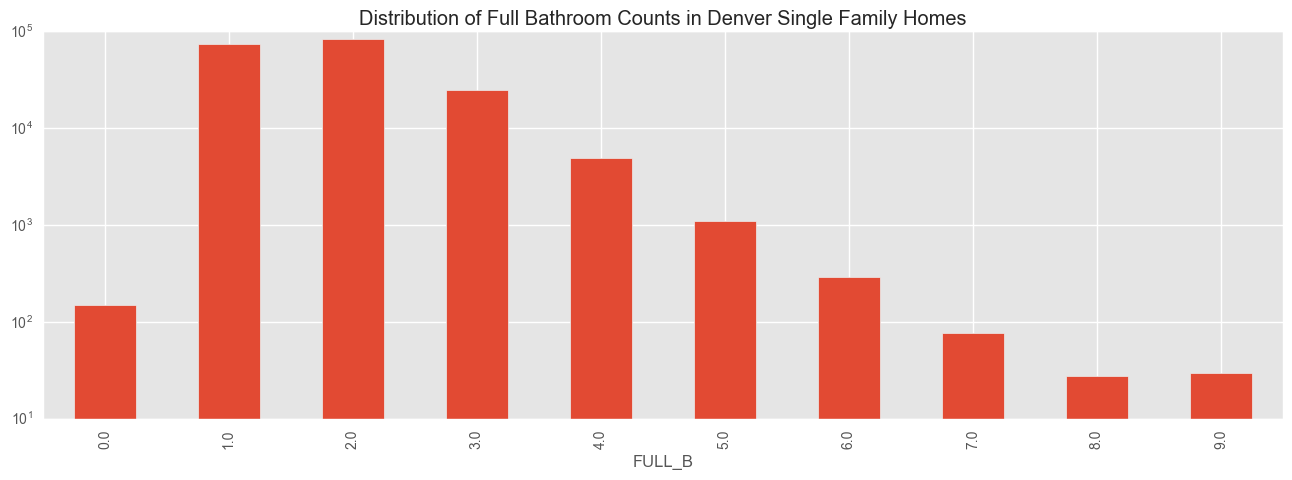

In [21]:
df_characteristics.groupby('FULL_B').size().plot(kind='bar', figsize=(16,5), 
                                                 title='Distribution of Full Bathroom Counts in Denver Single Family Homes', 
                                                  logy=True);

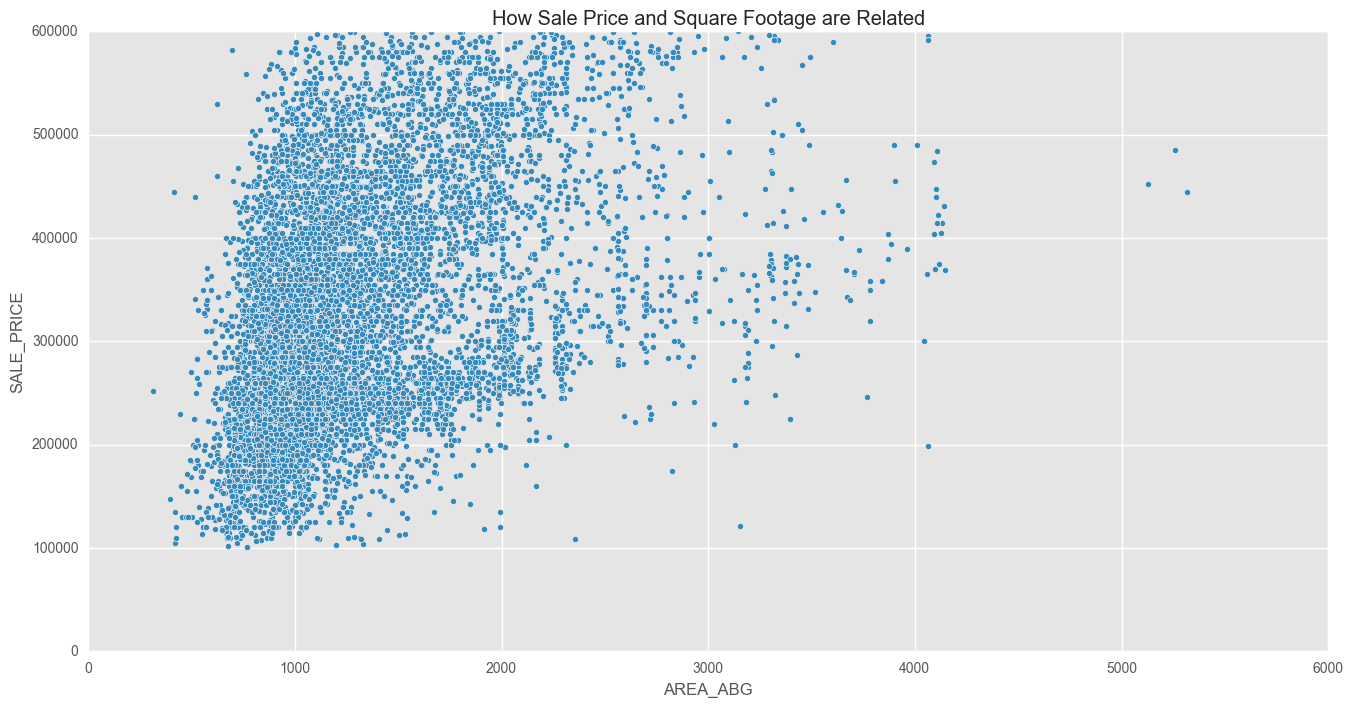

In [22]:
df_full_info[df_full_info.year == 2015].plot(x='AREA_ABG', 
                                             y='SALE_PRICE', 
                                             kind='scatter', 
                                             figsize=(16, 8), 
                                             xlim=(0, 6000),
                                             ylim=(0, 600000),
                                             title="How Sale Price and Square Footage are Related");

This visualization shows what I would expect--higher square footage correlates with a higher sale price. The gap in the middle of the homes makes me think there might be two or more different clusters in the data.

In [23]:
df_pairplot = df_full_info[['SALE_PRICE', 'LAND_SQFT', 'AREA_ABG', 'ASSESS_VALUE', 'ASMT_TAXABLE']].dropna()

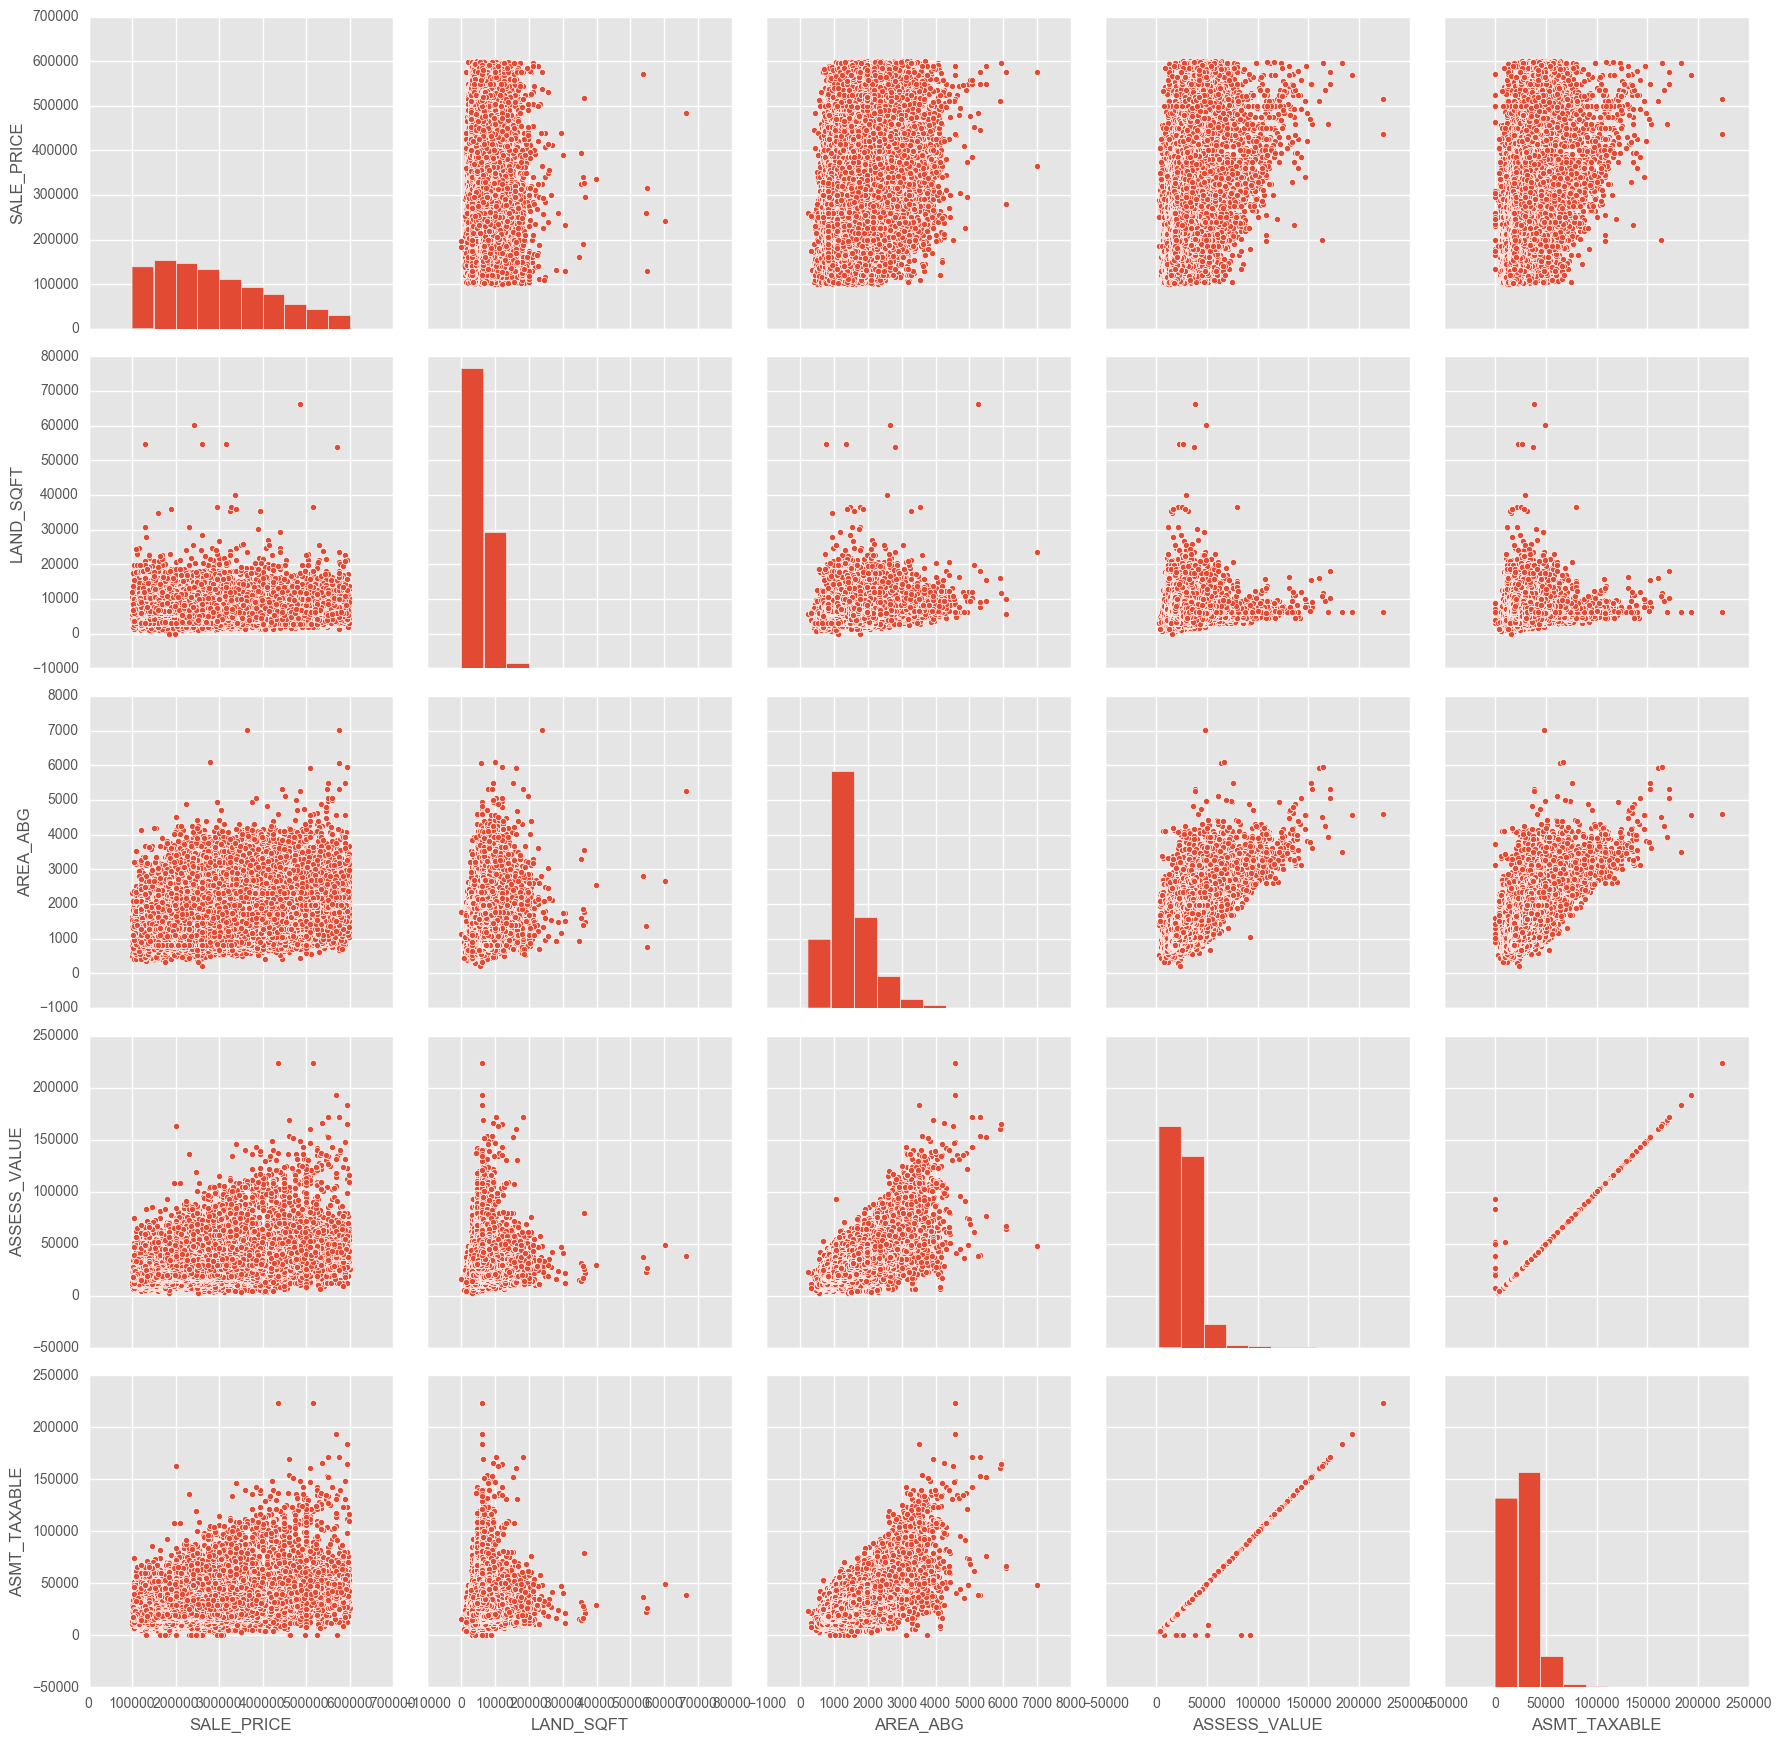

In [24]:
sns.pairplot(df_pairplot, size=3.5);

Looking at the pairplot above and then _df\_pairplot.describe()_ shows that there are some records that have zero as a value for _LAND\_SQFT_, _AREA\_ABG_, and _BED\_RMS_. I'll be looking into that in the near future. AREA_ABG and both ASSESS_VALUE and ASMT_TAXABLE have the positive correlation I would expect. It's also not a surprise that ASSESS_VALUE and ASMT_TAXABLE draw a nearly perfect 45 degree line. I'll need to drop one of those columns before running a regression.

The relationship of SALE_PRICE and all of the other variables is mostly unclear. At the lower end of each of the variables, there appears to be no discernable pattern.

### Feature Correlations

In preparation for the regression I will be modelling with this data, let's take a look at the variables to see if there might be any obvious correlation issues.

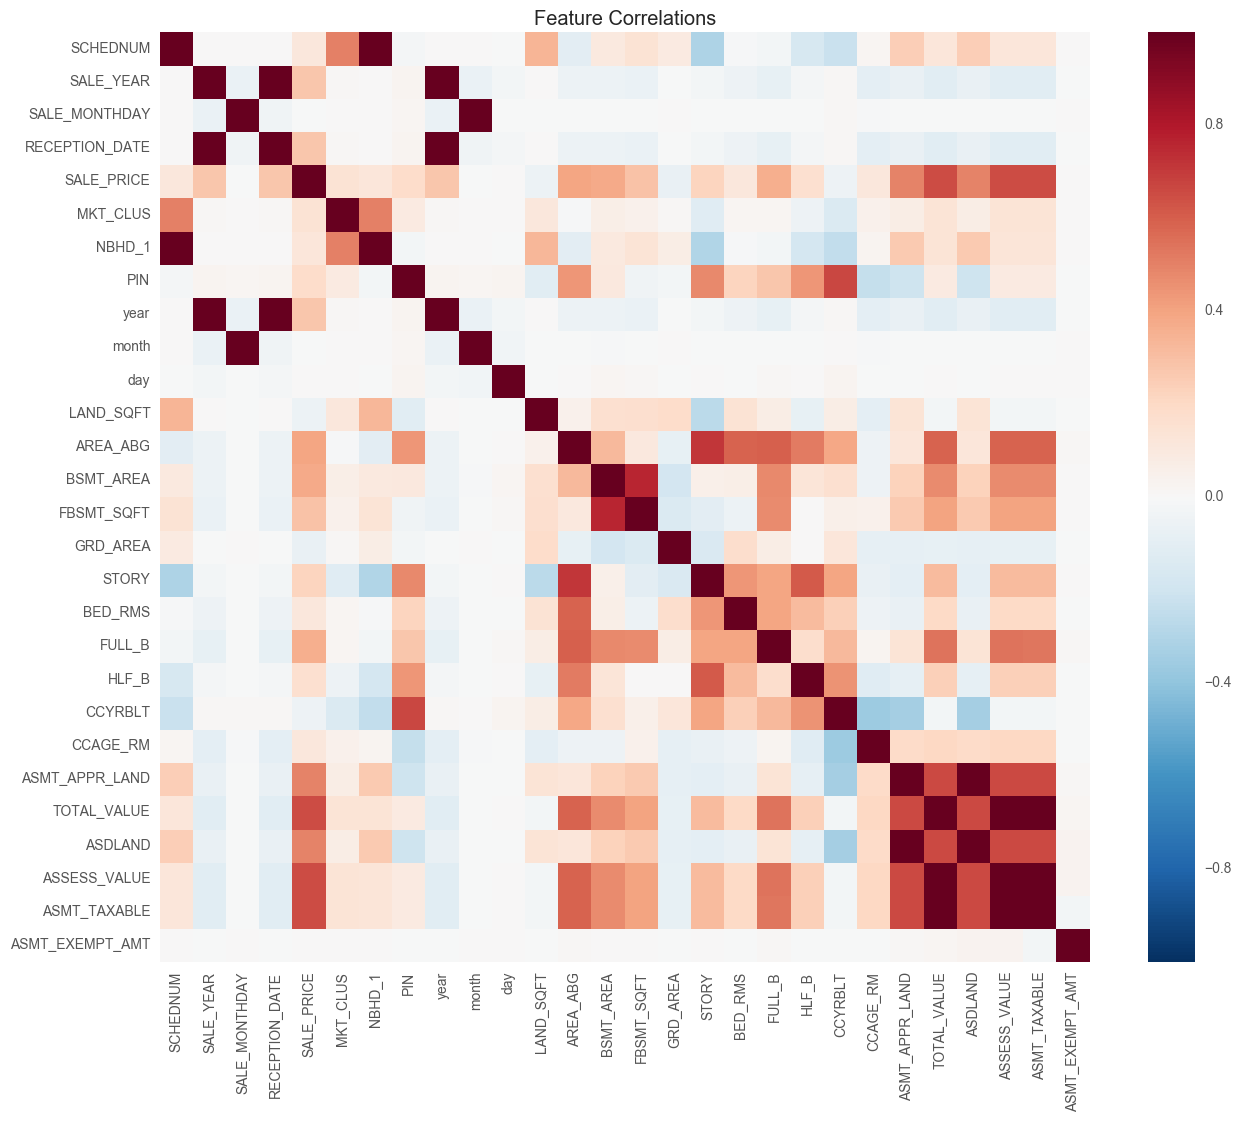

In [25]:
plt.figure(figsize=(15,12))
ax = sns.heatmap(df_full_info.corr())
plt.title("Feature Correlations")

plt.show()

In [26]:
df_full_info.corr()

,SCHEDNUM,SALE_YEAR,SALE_MONTHDAY,RECEPTION_DATE,SALE_PRICE,MKT_CLUS,NBHD_1,PIN,year,month,day,LAND_SQFT,AREA_ABG,BSMT_AREA,FBSMT_SQFT,GRD_AREA,STORY,BED_RMS,FULL_B,HLF_B,CCYRBLT,CCAGE_RM,ASMT_APPR_LAND,TOTAL_VALUE,ASDLAND,ASSESS_VALUE,ASMT_TAXABLE,ASMT_EXEMPT_AMT
SCHEDNUM,1.000,0.004,0.002,0.003,0.112,0.500,0.996,-0.019,0.004,0.002,-0.003,0.344,-0.102,0.100,0.143,0.087,-0.306,-0.012,-0.026,-0.171,-0.224,0.021,0.244,0.124,0.244,0.124,0.124,0.007
SALE_YEAR,0.004,1.000,-0.068,0.998,0.275,0.014,0.003,0.029,1.000,-0.067,-0.025,0.000,-0.059,-0.060,-0.068,-0.005,-0.030,-0.049,-0.083,-0.022,0.015,-0.095,-0.072,-0.111,-0.072,-0.111,-0.110,-0.002
SALE_MONTHDAY,0.002,-0.068,1.000,-0.046,-0.006,0.002,0.002,0.017,-0.068,1.000,-0.005,-0.004,-0.002,-0.007,-0.007,0.004,-0.001,-0.005,-0.002,-0.001,0.008,-0.008,-0.005,-0.004,-0.005,-0.004,-0.004,0.005
RECEPTION_DATE,0.003,0.998,-0.046,1.000,0.274,0.013,0.002,0.030,0.998,-0.045,-0.021,0.000,-0.058,-0.060,-0.068,-0.005,-0.029,-0.048,-0.083,-0.021,0.015,-0.096,-0.073,-0.112,-0.073,-0.111,-0.111,-0.002
SALE_PRICE,0.112,0.275,-0.006,0.274,1.000,0.145,0.119,0.180,0.275,-0.006,0.004,-0.062,0.392,0.382,0.291,-0.072,0.223,0.115,0.363,0.162,-0.049,0.110,0.499,0.656,0.499,0.656,0.655,0.003
MKT_CLUS,0.500,0.014,0.002,0.013,0.145,1.000,0.500,0.088,0.014,0.002,0.006,0.110,-0.011,0.067,0.054,0.015,-0.120,0.016,0.020,-0.055,-0.146,0.054,0.071,0.134,0.071,0.134,0.134,0.001
NBHD_1,0.996,0.003,0.002,0.002,0.119,0.500,1.000,-0.028,0.003,0.002,-0.003,0.331,-0.102,0.098,0.140,0.078,-0.304,-0.015,-0.028,-0.177,-0.246,0.029,0.260,0.133,0.260,0.133,0.132,0.007
PIN,-0.019,0.029,0.017,0.030,0.180,0.088,-0.028,1.000,0.029,0.016,0.028,-0.110,0.442,0.108,-0.044,-0.031,0.483,0.222,0.281,0.439,0.665,-0.241,-0.204,0.091,-0.204,0.091,0.091,-0.001
year,0.004,1.000,-0.068,0.998,0.275,0.014,0.003,0.029,1.000,-0.067,-0.025,0.000,-0.059,-0.060,-0.068,-0.005,-0.030,-0.049,-0.083,-0.022,0.015,-0.095,-0.072,-0.111,-0.072,-0.111,-0.110,-0.002
month,0.002,-0.067,1.000,-0.045,-0.006,0.002,0.002,0.016,-0.067,1.000,-0.034,-0.003,-0.002,-0.008,-0.007,0.004,-0.001,-0.005,-0.002,-0.002,0.007,-0.008,-0.005,-0.004,-0.005,-0.004,-0.004,0.004


Yes. There some features will need to be dropped in order to avoid problems due to high correlation.

In [27]:
df_full_info.dtypes

SCHEDNUM                     int64
RECEPTION_NUM               object
INSTRUMENT                  object
SALE_YEAR                    int64
SALE_MONTHDAY                int64
RECEPTION_DATE               int64
SALE_PRICE                 float64
GRANTOR                     object
GRANTEE                     object
CLASS                       object
MKT_CLUS                   float64
D_CLASS                     object
D_CLASS_CN                  object
NBHD_1                       int64
NBHD_1_CN                   object
PIN                          int64
date                datetime64[ns]
year                         int32
month                        int32
day                          int32
LAND_SQFT                  float64
AREA_ABG                   float64
BSMT_AREA                  float64
FBSMT_SQFT                 float64
GRD_AREA                   float64
STORY                      float64
STYLE_CN                    object
BED_RMS                    float64
FULL_B              

In [93]:
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import KFold
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn import metrics

In [29]:
X = df_full_info.select_dtypes(exclude=['object', 'datetime64'])
X = X.drop('SALE_PRICE', axis=1)
y = df_full_info['SALE_PRICE']

Now I need to create dummy variables for my year, month, and day columns.

In [30]:
year_dummies = pd.get_dummies(df_full_info.year, prefix='year', drop_first=True)
month_dummies = pd.get_dummies(df_full_info.month, prefix='month', drop_first=True)
day_dummies = pd.get_dummies(df_full_info.day, prefix='day', drop_first=True)
nbhd_dummies = pd.get_dummies(df_full_info.NBHD_1, prefix = 'nbhd', drop_first=True)
story_dummies = pd.get_dummies(df_full_info.STORY, prefix = 'story', drop_first=True)

In [31]:
X = pd.concat([X, year_dummies, month_dummies, day_dummies, nbhd_dummies, story_dummies], axis=1)

Setting up a training set and validation set:

In [32]:
X_train, X_validate, y_train, y_validate = train_test_split(X, y, test_size=.33, random_state=42)

The first model I'm going to run on the data is a linear regression. First I'll split the data into training and testing sets. Then I'll run a 10 fold cross-validation on the training set.

In [92]:
y_true = []
y_pred = []

folds = KFold(y_train.size, n_folds=10, random_state=42)

for train, test in folds:
    model = LinearRegression()
    model.fit(X_train.iloc[train], y_train.iloc[train])
    
    [y_true.append(result) for result in y_train.iloc[test]]
    [y_pred.append(result) for result in model.predict(X_train.iloc[test])] 

    rme = np.sqrt(mean_squared_error(y_true, y_pred))   
    
print "Root Mean Error: ", rme

Root Mean Error:  73376.192903


Not great, but it's a starting point.

Since I'll be running this model frequently, I'll put the model into a function.

In [97]:
def linear_model(X, y, n_folds=4, random_state=42):
    y_true = []
    y_pred = []

    #X_train, X_validate, y_train, y_validate = train_test_split(X, y, test_size=.33, random_state=42)

    folds = KFold(y_train.size, n_folds=n_folds, random_state=42)

    for train, test in folds:
        model = LinearRegression()
        model.fit(X_train.iloc[train], y_train.iloc[train])
    
        [y_true.append(result) for result in y_train.iloc[test]]
        [y_pred.append(result) for result in model.predict(X_train.iloc[test])] 

        rme = np.sqrt(mean_squared_error(y_true, y_pred))   
    
    print "Root Mean Error: ", rme 

After talking through the model with my data science mentor, I've realized that a few of the variables in the original model can be removed. Years are a continuous variable, so it doesn't make sense to turn them into dummy variables.

In [98]:
X_1 = df_full_info[['LAND_SQFT', 'BED_RMS', 'BSMT_AREA', 'ASMT_TAXABLE', 'GRD_AREA', 'CCYRBLT', 'year']]

X_1 = pd.concat([X_1, month_dummies, day_dummies, nbhd_dummies], axis=1)

In [99]:
linear_model(X_1, y_train)

Root Mean Error:  69684.0546993


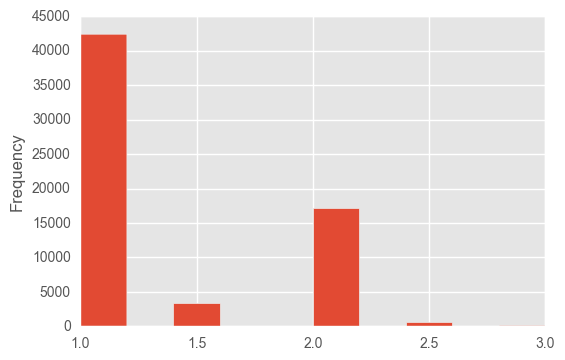

In [100]:
df_full_info.STORY.plot('hist')

In [101]:
X_alt_one = X_train[['LAND_SQFT', 'FULL_B', 'BSMT_AREA', 'TOTAL_VALUE', 'GRD_AREA', 'CCYRBLT', 'year']]

story_dummies = pd.get_dummies(df_full_info.STORY, prefix = 'story', drop_first=True)

X_alt_one = pd.concat([X_alt_one, month_dummies, day_dummies, nbhd_dummies, story_dummies], axis=1)

linear_model(X_alt_one, y_train)

Root Mean Error:  69684.0546993


Time for an alternate model! Adjustments to my linear regression model aren't making strong gains, so I'm going to use a random forest model in an attempt for better results.

In [102]:
from sklearn.ensemble import RandomForestRegressor

In [103]:
def forest_model(X, y, max_features="sqrt", test_size=.33, random_state=42):

    y_true = []
    y_pred = []

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.33, random_state=42)
    
    forest = RandomForestRegressor( max_features=max_features, random_state=random_state)

    forest.fit(X_train, y_train)

    rf_me = np.sqrt(mean_squared_error(y_test, forest.predict(X_test)))
    
    print "Mean Error: ", rf_me
    
    return forest, X_test

In [127]:
def forest_model(X, y, max_features="sqrt", test_size=.33, n_folds=4, random_state=42):
    
    y_true = []
    y_pred = []
    
    folds = KFold(y.size, n_folds=n_folds, random_state=random_state)

    for train, test in folds:
        forest = RandomForestRegressor(max_features=max_features, random_state=random_state)
        forest.fit(X.iloc[train], y.iloc[train])
        
        [y_true.append(result) for result in y.iloc[test]]
        [y_pred.append(result) for result in forest.predict(X.iloc[test])]
    
    rme = np.sqrt(mean_squared_error(y_true, y_pred))
    
    print "Root Mean Error: ", rme

In [128]:
forest_model(X_train, y_train)

Root Mean Error:  56430.316182


In [78]:
from sklearn import cross_validation

In [129]:
def forest_model(X, y, max_features="sqrt", test_size=.33, n_folds=4, random_state=42):
    
    folds = KFold(y.size, n_folds=n_folds, random_state=random_state)
    forest = RandomForestRegressor(max_features=max_features)
    mse_scorer = metrics.make_scorer(mean_squared_error)
    results = cross_validation.cross_val_score(forest, X, y, cv=folds, scoring=mse_scorer)
   
    print "RME: ", np.sqrt(results.mean())

In [130]:
forest_model(X_train, y_train)

RME:  56457.6821063


In [81]:
cross_validation.cross_val_score?

In [ ]:
rf_features = pd.DataFrame({"feature name": X_test.columns, 
                            "feature importance": forest.feature_importances_})
rf_features.sort_values(by="feature importance", ascending=False)

In [ ]:
X_alt_two = df_full_info[['LAND_SQFT', 'FULL_B', 'BSMT_AREA', 'TOTAL_VALUE', 'GRD_AREA', 'CCYRBLT', 'year']]

story_dummies = pd.get_dummies(df_full_info.STORY, prefix = 'story', drop_first=True)

X_alt_two = pd.concat([X_alt_two, month_dummies, nbhd_dummies, story_dummies], axis=1)

linear_model(X_alt_two, y)

In [ ]:
forest, X_test = forest_model(X_alt_two, y)

In [ ]:
X_alt_3 = df_full_info[['AREA_ABG', 'BSMT_AREA', 'TOTAL_VALUE', 'GRD_AREA', 'CCYRBLT', 'year']]

X_alt_3 = pd.concat([X_alt_3, month_dummies, nbhd_dummies], axis=1)

linear_model(X_alt_3, y)

In [ ]:
forest, X_test = forest_model(X_alt_3, y)

In [ ]:
def forest_model_2(X, y, max_features="sqrt", test_size=.33, random_state=42):

    y_true = []
    y_pred = []

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.33, random_state=42)

    forest = RandomForestRegressor( max_features=max_features, random_state=random_state)

    forest.fit(X_train, y_train)

    rf_me = np.sqrt(mean_squared_error(y_test, forest.predict(X_test)))
    
    print "Mean Error: ", rf_me
    
    return forest, X_test